 TODO:
- Add windows at different scales: DONE
- Improve algorithm to find cars: DONE
- deal with false positives: DONE BY ADDING ADDITIONAL THRESHOLD

In [81]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import os
import time
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.patches as mpatches

In [2]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    '''Draws boxed on an image by using the cv2.rectangle function'''
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(draw_img, tuple(bbox[0]), tuple(bbox[1]), color, thick)
        
    return draw_img

def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''function to extract the color channel histagram features'''
    img = mpimg.imread('./test_images/test1.jpg')
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0: len(bin_edges)-1])/2
    
    return hist_features

### Visualizing the hsitogram features

(0, 256)

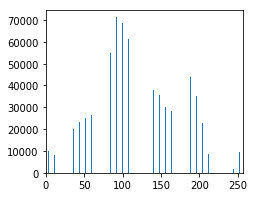

In [3]:
# Trying out the histograms
img = mpimg.imread('./test_images/test1.jpg')

rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))

bin_edges = rhist[1]
bin_centers = (bin_edges[1:] + bin_edges[0: len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0,256)


In [4]:
hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

### Visualizing Color Space channels to understand which channel might be more useful for classification.

In [5]:
def plot3d(pixels, colors_rgb, axis_labels=list("RBG"), axis_limits=((0,255), (0, 255), (0,255))):
    
    #create gigure in 3d space
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0],fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1],fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2],fontsize=16, labelpad=16)
    
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none'
    )
    
    return ax

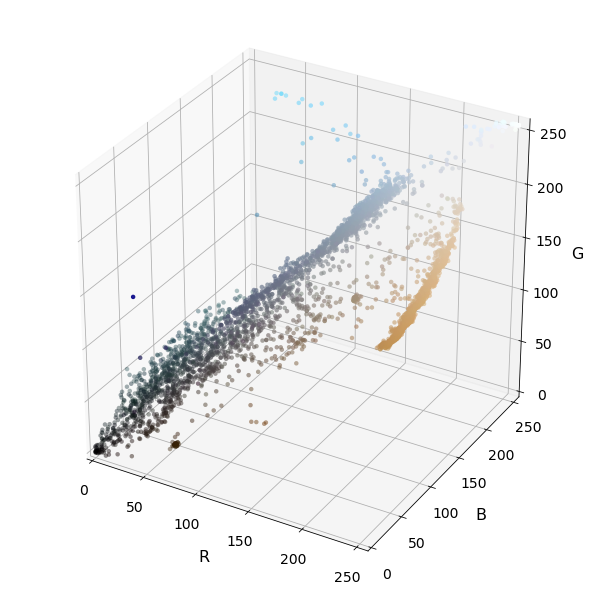

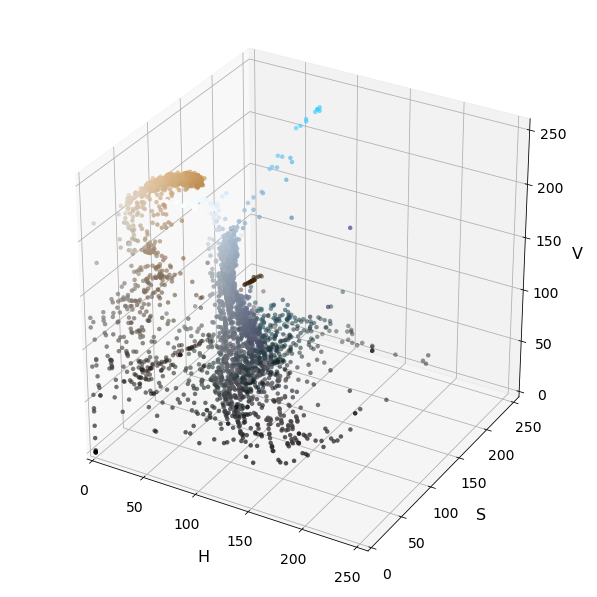

In [6]:
scale = max(img.shape[0], img.shape[1], 64)/64
img_small = cv2.resize(img, (np.int(img.shape[1]/ scale), np.int(img.shape[1]/ scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB/255

plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()
# Note : Saturation channel is king

In [7]:
def bin_spatial(img, size=(32, 32)):
    '''Returns image to a new color space'''
    resized = cv2.resize(img, size)
    return resized.ravel(), resized      

In [9]:
%matplotlib inline
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''Helper function to extract the Histogram of Gradients Features'''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


### Visualizing HOG Features

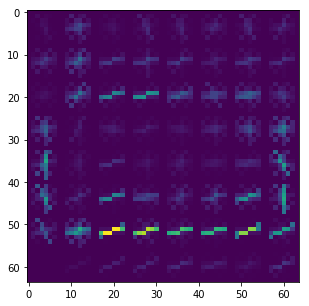

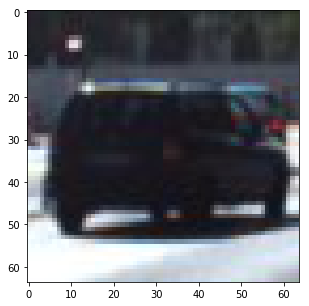

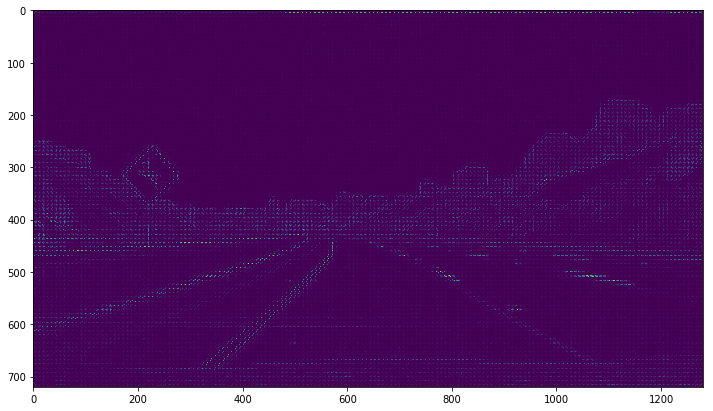

In [118]:
# Calculating HOGs
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

car_img = mpimg.imread('./vehicles_smallset/cars1/2.jpeg')
hsv_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2HSV)
hog_features, hog_image = get_hog_features(hsv_img[:,:,2], orient, pix_per_cell,cell_per_block, vis=True)
plt.figure(figsize=(6,5))
plt.imshow(hog_image)
plt.savefig("./writeup_imgs/hog_feat.jpg")
plt.figure(figsize=(6,5))
plt.imshow(car_img)
plt.savefig("./writeup_imgs/hog_feat_og.jpg")

hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
hog_features, hog_image = get_hog_features(hsv_img[:,:,2], orient, pix_per_cell,cell_per_block, vis=True)
plt.figure(figsize=(12,10))
plt.imshow(hog_image)
plt.savefig("./writeup_imgs/hog_feat_frame.jpg")

In [24]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    '''This functions extracts the color space, spatial, color histogram and HOG features
    for a given image based on the parameters'''
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)[0]
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [25]:
def extract_features(imgs, color_space='RGB',orient=9, pix_per_cell=8, cell_per_block=2,
                     spatial_size=(32,32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    '''Helper function '''
    features = []
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        
        
        file_features = single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        
        features.append(file_features)
    
    return features

### Training the model based on car images and hog features

In [26]:
absolute_path = './'
car_images = glob.glob(os.path.join(absolute_path, 'vehicles/*/*.png'))
not_car_images = glob.glob(os.path.join(absolute_path, 'non-vehicles/*/*.png'))

# car_images = glob.glob(os.path.join(absolute_path, 'vehicles_smallset/*/*.jpeg'))
# not_car_images = glob.glob(os.path.join(absolute_path, 'non-vehicles_smallset/*/*.jpeg'))

color_space = 'HSV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2
spatial = 32
histbin = 32

car_features = extract_features(car_images, color_space=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256), hog_channel=hog_channel,
                               spatial_feat=True, hist_feat=True)

notcar_features = extract_features(not_car_images, color_space=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256), hog_channel=hog_channel,
                                  spatial_feat=True, hist_feat=True)

In [27]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
Y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
len(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rand_state)

In [28]:
X_scaler = StandardScaler().fit(X_train)

# Applying scaler
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print ('Using spatial binding of:', spatial, 'and', histbin, 'histogram bins')
print('Feature vector lenght:', len(X_train[0]))


# Now training using SVM
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# svr = svm.SCV()
# clf = grid_search.GridSearchCV(svr, parameters)

# Using Linear SVC
svc = LinearSVC()
# svc = CalibratedClassifierCV(svm)
# Chcking the training time
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC')
print ('Test Accuracy of SVC = ',  round(svc.score(X_test, y_test), 4))

Using spatial binding of: 32 and 32 histogram bins
Feature vector lenght: 4932
24.65 Seconds to train SVC
Test Accuracy of SVC =  0.9589


In [29]:
# Checking for time for single sample
t = time.time()
n_predict = 10
print ('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print ('For these',n_predict, 'labels: ' , y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict SVC')

My SVC predicts:  [0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
For these 10 labels:  [0. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
0.01 Seconds to predict SVC


In [30]:
def slide_window(img, x_start_stop=[0, 32], y_start_stop=[0, 32],
                 xy_window=(4,4), xy_overlap=(0.5, 0.5)):
    '''Returns an array of windows on image given xy stary and stop paramters, window size and overlap'''
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    
    # Fix the overlap somehow. TODO
    nx_windows = np.int((xspan - nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step)
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Starting at the end of the image
            
            # Lets get the end window first'
            endx = x_start_stop[1] - (xs)*nx_pix_per_step
#             startx =  x_start_stop[1] - (xs)*nx_pix_per_step
            startx = endx - xy_window[0]
#             endx = endx + xy_window[0]
            starty = ys * ny_pix_per_step  + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list
    

In [91]:
window_side = 20
y_shift = 4
overlap = 0.6
y_bound_fn = lambda scale, y_shift, window_side: [415 - y_shift*scale, 415 + window_side*scale - y_shift*scale]
x_start_fn = lambda scale: 550 - scale*24
window_shape = np.array([window_side, window_side])

# windows1 = slide_window(img, x_start_stop=[0, 1280], y_start_stop=[400, 720],
#                        xy_window=(142, 152), xy_overlap=(0, 0))

scale = 2
print(y_bound_fn(scale, y_shift, window_side))
windows1 = slide_window(img, x_start_stop=[550, 1000], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 4
windows2 = slide_window(img, x_start_stop=[550, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 5
windows3 = slide_window(img, x_start_stop=[500, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 6
windows4 = slide_window(img, x_start_stop=[400, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 7
windows5 = slide_window(img, x_start_stop=[350, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 8
windows6 = slide_window(img, x_start_stop=[350, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, 0.))

scale = 10
windows10 = slide_window(img, x_start_stop=[250, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, overlap))

scale = 12
windows12 = slide_window(img, x_start_stop=[250, 1280], y_start_stop=y_bound_fn(scale, y_shift, window_side),
                       xy_window=window_shape*scale, xy_overlap=(overlap, overlap))


windows_test = np.concatenate((windows1, windows2, windows3, windows4, windows5, windows6, windows10, windows12))
windows = []
# windows.extend(slide_window(img, x_start_stop=[0, 1280], y_start_stop=[400, 400 + window_side*1],
#                        xy_window=window_shape, xy_overlap=(0., 0.)))

for scale in range(2, 10):
#     print (400 + window_side*scale*2)
#     y_max_factor = 2 if 400 + window_side*scale*2 < 720 else 1
    scaled_window = slide_window(img, x_start_stop=[0, 1280], y_start_stop=[400, 400 + window_side*scale],
                       xy_window=window_shape*scale, xy_overlap=(overlap, overlap))
    windows.extend(scaled_window)

    

[407, 447]


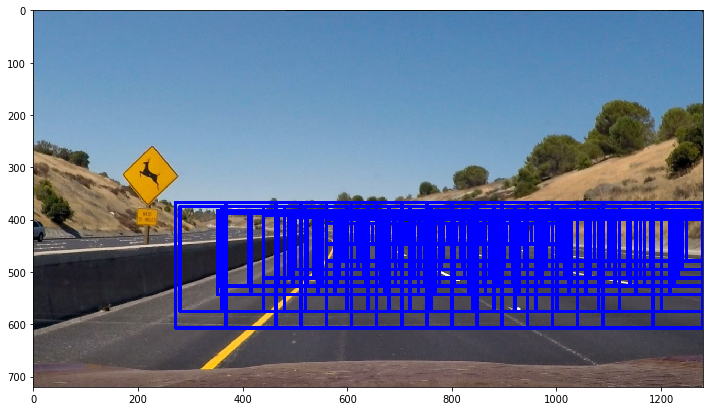

In [92]:
%matplotlib inline

# window_img = draw_boxes(img, np.concatenate(( windows1, )))

window_img = draw_boxes(img, windows_test)

plt.figure(figsize=(12,10))
windows = windows_test 
plt.imshow(window_img)
plt.savefig("./writeup_imgs/windows.jpg")

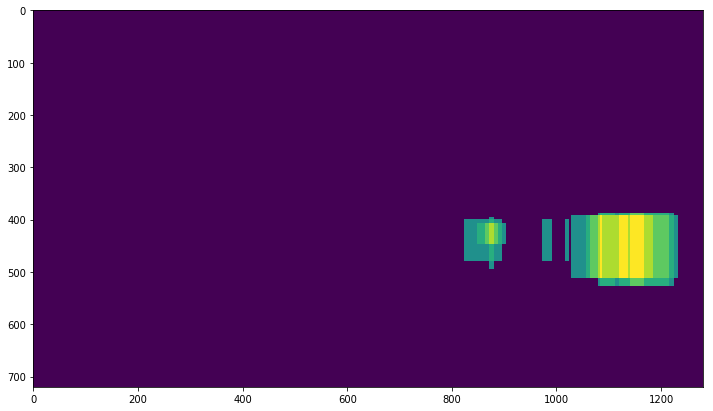

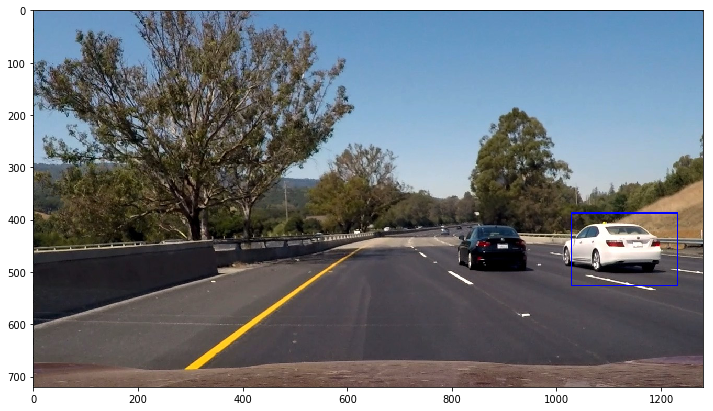

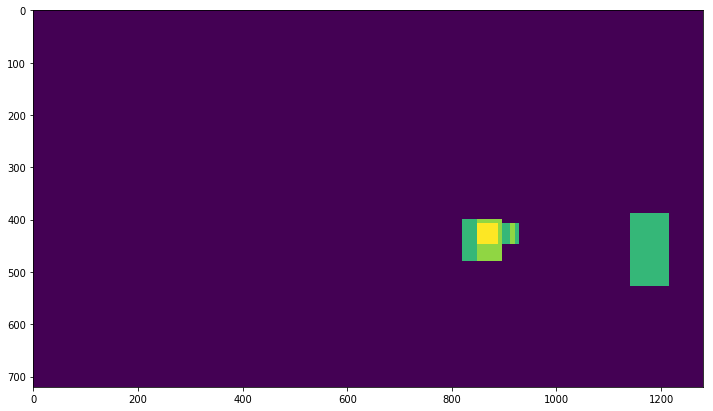

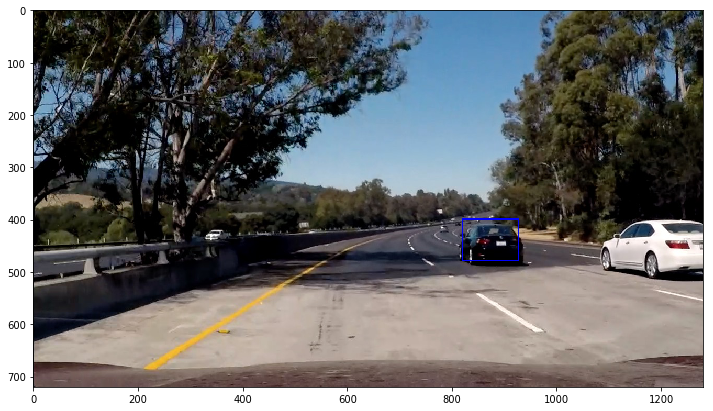

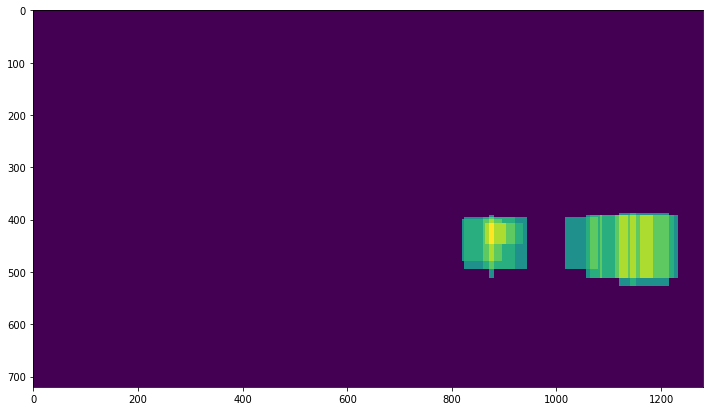

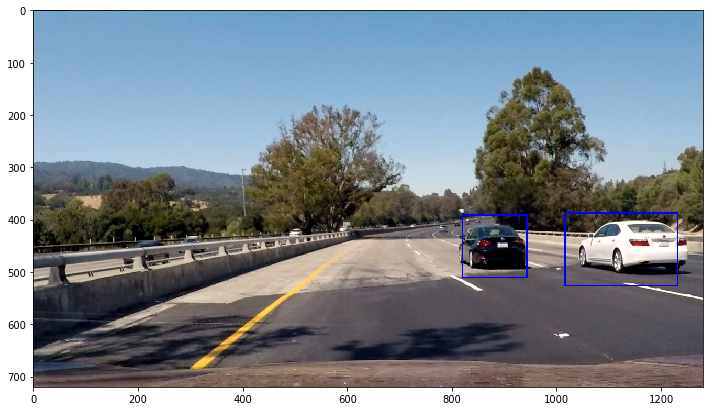

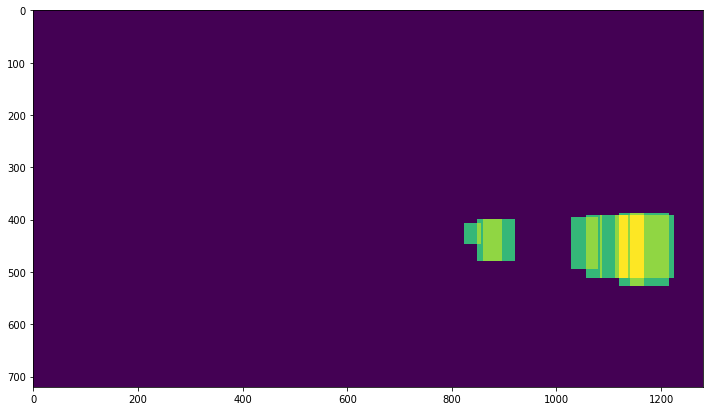

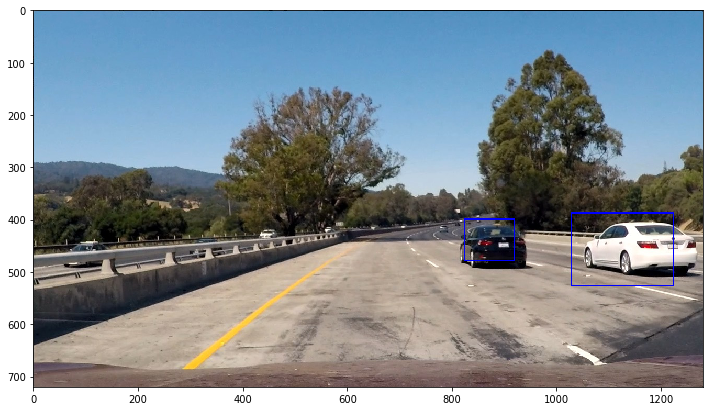

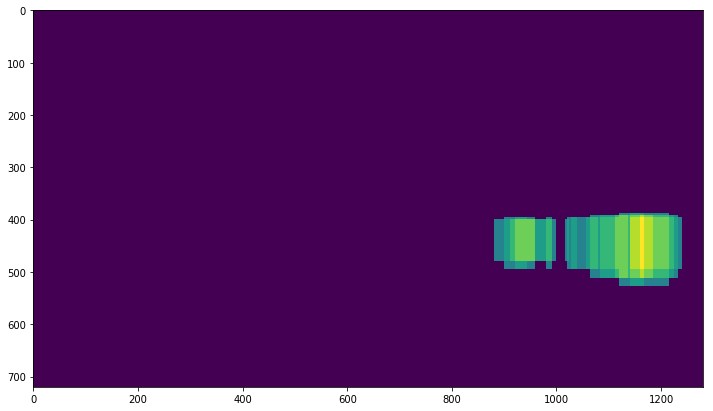

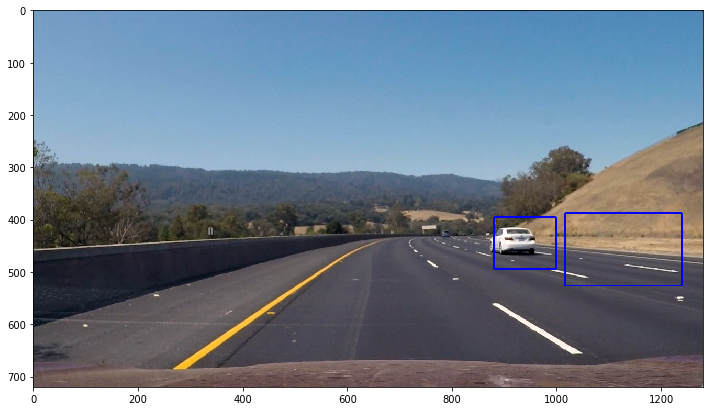

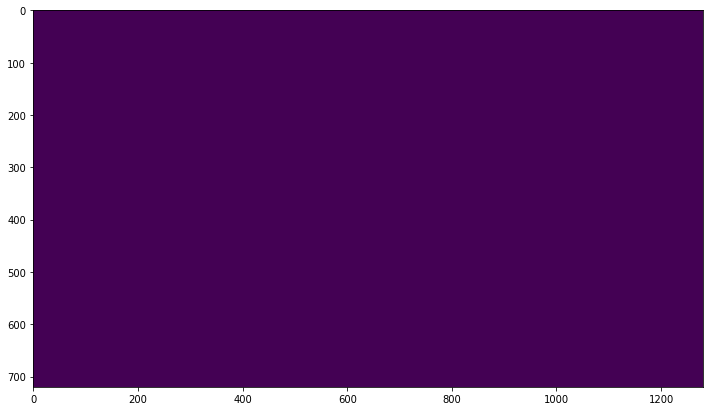

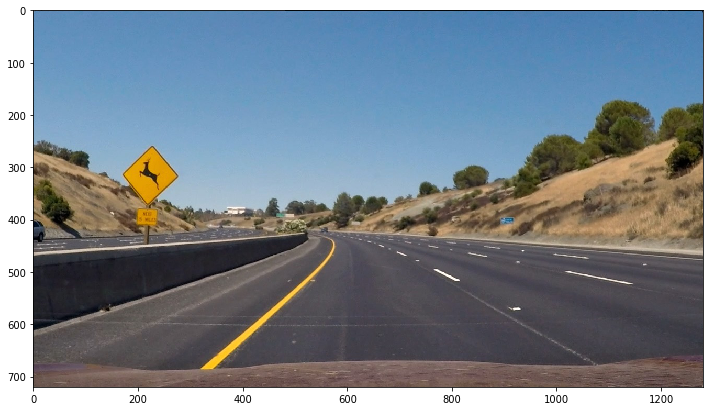

In [105]:
test_images = glob.glob(os.path.join(absolute_path, './test_images/*.jpg'))

pred = []
prob = []
for index, file in enumerate(test_images):
    img = mpimg.imread(file)
    
    draw_img, predictions, probabilities = get_final_image(img, 3, windows)
    pred.extend(predictions)
    prob.extend(probabilities)
    # print(labels[1], "car_found")
    cv2.destroyAllWindows()

    plt.figure(figsize=(12,10))
    plt.imshow(draw_img)
    plt.savefig("./writeup_imgs/%i_sample_test.jpg" % index)

### Plotting the clf.decision_function and prediction in order to add an additional threshold to the classifier

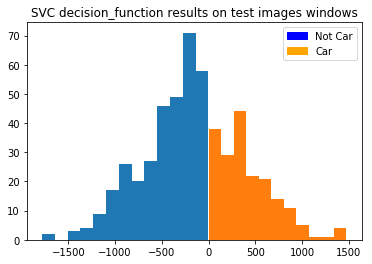

In [84]:
# len(p ), len(prob)
# plt.figure(figsize=(8,6))
# plt.scatter(prob, p)

non_car_pred = []
car_pred = []
for po, pr in zip(prob, pred):
    if pr == 1:
        car_pred.extend(po)
    else:
        non_car_pred.extend(po)

plt.hist(non_car_pred, bins='auto')
plt.hist(car_pred, bins='auto')
plt.title("SVC decision_function results on test images windows")
blue_patch = mpatches.Patch(color='blue', label='Not Car')
orange_patch = mpatches.Patch(color='orange', label='Car')

plt.legend(handles=[blue_patch, orange_patch])
plt.savefig("./writeup_imgs/decision_function_hist.jpg")

In [67]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    predictions = []
    probabilities = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        
        prediction = clf.predict(test_features)
        y_proba = clf.decision_function(test_features)

        predictions.append(prediction)
        probabilities.append(y_proba)
        
        #7) If positive (decision_function > 450) then save the window
        if y_proba > 450:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows, predictions, probabilities

In [68]:
def is_valid_car_box(window):
    width = window[1][0] -  window[0][0]
    length = window[1][1] -  window[0][1]
    return width >= length

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        #Adding one to all the pixels inside each box
#         temp_img = draw_boxes(draw_image, [box], color=(0, 0, 255), thick=2)                    
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Removing all of the pixels that are smaller than the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap


def get_labeled_boxes(labels):
    label_boxes = []
    for car_number in range(1, labels[1] + 1):
        # Finding pixels per car number
        nonzero = (labels[0] == car_number).nonzero()
        
        #Getting x and y non zero pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Drawing the box over the image
        if is_valid_car_box(bbox):
            label_boxes.append(bbox)
    
    return label_boxes
        

In [110]:
def get_final_image(img, threshold, windows):

    hot_windows, predictions, probabilities = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=(spatial, spatial), hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=True, hog_feat=True) 
    
    draw_image = np.copy(img)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    


    # Applying heatmap to hot_windows
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    thresholded_heatmap = apply_threshold(heatmap, threshold)

    # Labeling the heatspots
    labels = label(thresholded_heatmap)
    labels_boxes = get_labeled_boxes(labels)
    
    # code used to save heat imgs
    plt.figure(figsize=(12,10))
    plt.imshow(thresholded_heatmap)
    plt.savefig("./writeup_imgs/%i_heat_map.jpg" % img[1][100][2])
    draw_img = draw_boxes(draw_image, labels_boxes, color=(0, 0, 255), thick=2)       
    return draw_img, predictions, probabilities

In [70]:
class FindCar():
    def __init__(self, heat_threshold, hot_win_retention=8): 
        self.windows = windows
        self.prev_hot_rolling_windows = []
        self.confidence_threshold = 2
        self.frame_number = 0
        
        self.heat_threshold = heat_threshold
        self.hot_windows_hist = []
        self.win_retention = hot_win_retention
    
    
    def get_hot_windows(self, frame):
        curr_hot_windows, predictions, probabilities = search_windows(
            frame, self.windows, svc, X_scaler, color_space=color_space, 
            spatial_size=(spatial, spatial), hist_bins=histbin, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=True, 
            hist_feat=True, hog_feat=True) 
        
        # Getting historical hot_windows
        hot_windows = self.get_hist_hot_windows(curr_hot_windows)
        
        # Applying heatmap to hot_windows
        heat = np.zeros_like(img[:, :, 0]).astype(np.float)
        heatmap = add_heat(heat, hot_windows)
        thresholded_heatmap = apply_threshold(heatmap, self.heat_threshold)

        # Labeling the heatspots
        labels = label(thresholded_heatmap)
        return get_labeled_boxes(labels)
    
    def find_cars(self, frame):
        curr_hot_labeled_windows = self.get_hot_windows(frame)
#         if self.frame_number == 0 or self.prev_hot_rolling_windows == []:
#             self.prev_hot_rolling_windows = curr_hot_labeled_windows
#             valid_windows = curr_hot_labeled_windows
#             self.frame_number += 1
        
#         else:
#             valid_windows = self.check_window_hist(self.prev_hot_rolling_windows, curr_hot_labeled_windows)
#             self.prev_hot_rolling_windows = valid_windows
        #Overriding for now
        valid_windows = curr_hot_labeled_windows
        draw_img = draw_boxes(frame, valid_windows, color=(0, 0, 255), thick=2)       
        return draw_img
    
    def check_window_hist(self, prev_windows, curr_windows):
        '''Compare previous and current windows, returning the current windows 
        that were present on the previous windows'''
        pixel_threshold = 50
        
        valid_windows = []
        for c_win in curr_windows:
            for p_win in prev_windows:
                
                if self.are_windows_close(c_win, p_win, pixel_threshold):
                    valid_windows.append(c_win)
        
        return valid_windows
        
    
    def are_windows_close(self, win_1, win_2, threshold):
        '''Checks if two windows are close together based on a pixel distance threshold'''
        import functools
        x_diff = [abs(win_1[0][0] - win_2[0][0]), abs(win_1[1][0] - win_2[1][0])]
        
        y_diff = [abs(win_1[0][1] - win_2[0][1]), abs(win_1[1][1] - win_2[1][1])]
        
        pix_dist_diff = x_diff + y_diff
        
        return functools.reduce(lambda x, y: x and y, list(map(lambda x: x < threshold,  pix_dist_diff)))
    
    def get_hist_hot_windows(self, curr_hot_windows):
        np_hot_windows = np.array(curr_hot_windows)
        
        # Return current how windows hist in case the current hot window is empty
        if np_hot_windows.size == 0:
            return np.concatenate(self.hot_windows_hist)
        
        if len(self.hot_windows_hist) == self.win_retention:
            self.hot_windows_hist.pop(0)
        
        self.hot_windows_hist.append(np_hot_windows)
        hot_windows = np.concatenate(self.hot_windows_hist)
        
        return hot_windows
    

False

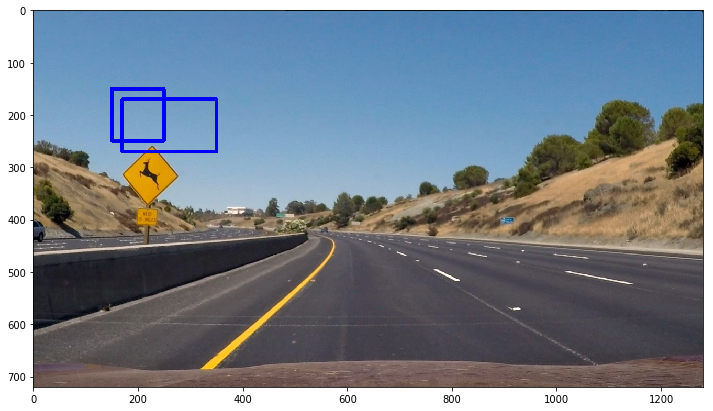

In [71]:
%matplotlib inline

# Testing out are_windows_close box function
window1 = [[150, 150], [250, 250]]
window2 = [[170, 170], [350, 270]]

window_img = draw_boxes(img, (window1, window2))
plt.figure(figsize=(12,10))
windows = windows_test 
plt.imshow(window_img)

car_finder = FindCar(heat_threshold=5)
car_finder.are_windows_close(window1, window2, 50)

In [72]:
%matplotlib qt

cv2.destroyAllWindows()
cap = cv2.VideoCapture('./project_video.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('outpy_final_6_450_15t_8r_video.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")


# Read until video is completed
n_frame = 1
car_finder = FindCar(heat_threshold=15)
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        
        print("Frame Num:", n_frame)
        n_frame += 1
        # Writing out processed frames
        out.write(car_finder.find_cars(frame))
        
        #Show the frame
        cv2.imshow('Frame', car_finder.find_cars(frame))
                
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # Break the loop
    else: 
        break

Frame Num: 1
Frame Num: 2
Frame Num: 3
Frame Num: 4
Frame Num: 5
Frame Num: 6
Frame Num: 7
Frame Num: 8
Frame Num: 9
Frame Num: 10
Frame Num: 11
Frame Num: 12
Frame Num: 13
Frame Num: 14
Frame Num: 15
Frame Num: 16
Frame Num: 17
Frame Num: 18
Frame Num: 19
Frame Num: 20
Frame Num: 21
Frame Num: 22
Frame Num: 23
Frame Num: 24
Frame Num: 25
Frame Num: 26
Frame Num: 27
Frame Num: 28
Frame Num: 29
Frame Num: 30
Frame Num: 31
Frame Num: 32
Frame Num: 33
Frame Num: 34
Frame Num: 35
Frame Num: 36
Frame Num: 37
Frame Num: 38
Frame Num: 39
Frame Num: 40
Frame Num: 41
Frame Num: 42
Frame Num: 43
Frame Num: 44
Frame Num: 45
Frame Num: 46
Frame Num: 47
Frame Num: 48
Frame Num: 49
Frame Num: 50
Frame Num: 51
Frame Num: 52
Frame Num: 53
Frame Num: 54
Frame Num: 55
Frame Num: 56
Frame Num: 57
Frame Num: 58
Frame Num: 59
Frame Num: 60
Frame Num: 61
Frame Num: 62
Frame Num: 63
Frame Num: 64
Frame Num: 65
Frame Num: 66
Frame Num: 67
Frame Num: 68
Frame Num: 69
Frame Num: 70
Frame Num: 71
Frame Num: 72
F

Frame Num: 555
Frame Num: 556
Frame Num: 557
Frame Num: 558
Frame Num: 559
Frame Num: 560
Frame Num: 561
Frame Num: 562
Frame Num: 563
Frame Num: 564
Frame Num: 565
Frame Num: 566
Frame Num: 567
Frame Num: 568
Frame Num: 569
Frame Num: 570
Frame Num: 571
Frame Num: 572
Frame Num: 573
Frame Num: 574
Frame Num: 575
Frame Num: 576
Frame Num: 577
Frame Num: 578
Frame Num: 579
Frame Num: 580
Frame Num: 581
Frame Num: 582
Frame Num: 583
Frame Num: 584
Frame Num: 585
Frame Num: 586
Frame Num: 587
Frame Num: 588
Frame Num: 589
Frame Num: 590
Frame Num: 591
Frame Num: 592
Frame Num: 593
Frame Num: 594
Frame Num: 595
Frame Num: 596
Frame Num: 597
Frame Num: 598
Frame Num: 599
Frame Num: 600
Frame Num: 601
Frame Num: 602
Frame Num: 603
Frame Num: 604
Frame Num: 605
Frame Num: 606
Frame Num: 607
Frame Num: 608
Frame Num: 609
Frame Num: 610
Frame Num: 611
Frame Num: 612
Frame Num: 613
Frame Num: 614
Frame Num: 615
Frame Num: 616
Frame Num: 617
Frame Num: 618
Frame Num: 619
Frame Num: 620
Frame Num:

Frame Num: 1095
Frame Num: 1096
Frame Num: 1097
Frame Num: 1098
Frame Num: 1099
Frame Num: 1100
Frame Num: 1101
Frame Num: 1102
Frame Num: 1103
Frame Num: 1104
Frame Num: 1105
Frame Num: 1106
Frame Num: 1107
Frame Num: 1108
Frame Num: 1109
Frame Num: 1110
Frame Num: 1111
Frame Num: 1112
Frame Num: 1113
Frame Num: 1114
Frame Num: 1115
Frame Num: 1116
Frame Num: 1117
Frame Num: 1118
Frame Num: 1119
Frame Num: 1120
Frame Num: 1121
Frame Num: 1122
Frame Num: 1123
Frame Num: 1124
Frame Num: 1125
Frame Num: 1126
Frame Num: 1127
Frame Num: 1128
Frame Num: 1129
Frame Num: 1130
Frame Num: 1131
Frame Num: 1132
Frame Num: 1133
Frame Num: 1134
Frame Num: 1135
Frame Num: 1136
Frame Num: 1137
Frame Num: 1138
Frame Num: 1139
Frame Num: 1140
Frame Num: 1141
Frame Num: 1142
Frame Num: 1143
Frame Num: 1144
Frame Num: 1145
Frame Num: 1146
Frame Num: 1147
Frame Num: 1148
Frame Num: 1149
Frame Num: 1150
Frame Num: 1151
Frame Num: 1152
Frame Num: 1153
Frame Num: 1154
Frame Num: 1155
Frame Num: 1156
Frame Nu

In [73]:
# When everything done, release the video capture object
cap.release()
out.release()